In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
%matplotlib inline
sns.set(style='ticks',context='poster')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_98911/786773502.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_98911/244831670.py:28: FutureWarning: The provided callable <function mean at 0x115bd5bc0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_pivot = pd.pivot_table(df_selected, values='auc', index=column_temp, columns=[name], aggfunc=np.mean)
/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_98911/244831670.py:28: FutureWarning: The provided callable <function mean at 0x115bd5bc0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_pivot = pd.pivot_table(df_selected, values='auc', index=column_temp, columns=[name], aggfunc=np.mean)
/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_98911/244831670.py:28: FutureWarning: The provided callable <function mean at

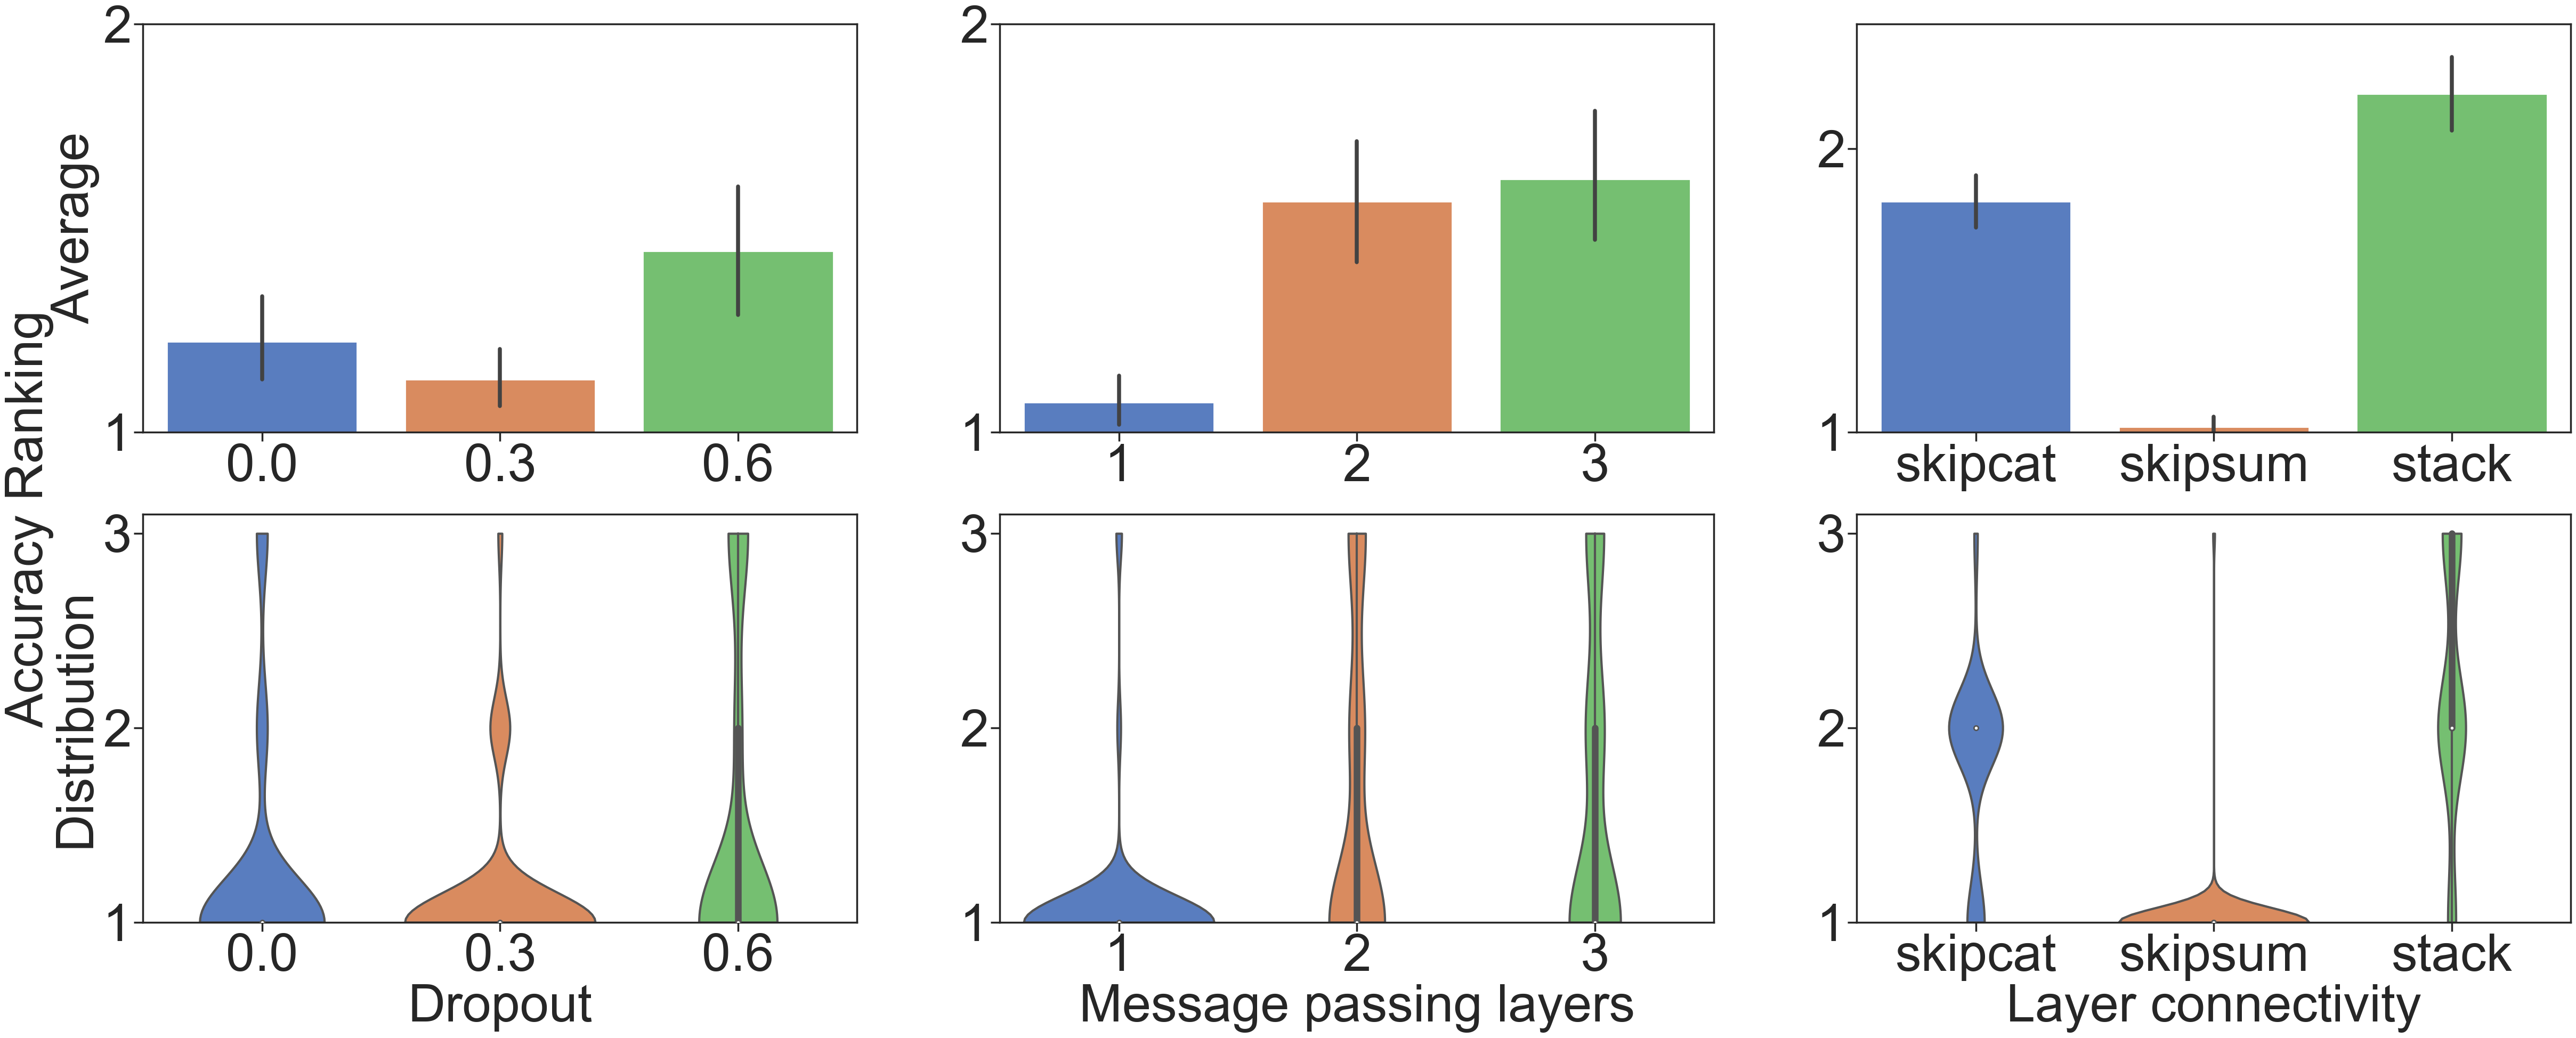

/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_98911/244831670.py:28: FutureWarning: The provided callable <function mean at 0x115bd5bc0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_pivot = pd.pivot_table(df_selected, values='auc', index=column_temp, columns=[name], aggfunc=np.mean)
/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_98911/244831670.py:28: FutureWarning: The provided callable <function mean at 0x115bd5bc0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_pivot = pd.pivot_table(df_selected, values='auc', index=column_temp, columns=[name], aggfunc=np.mean)
/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_98911/244831670.py:28: FutureWarning: The provided callable <function mean at

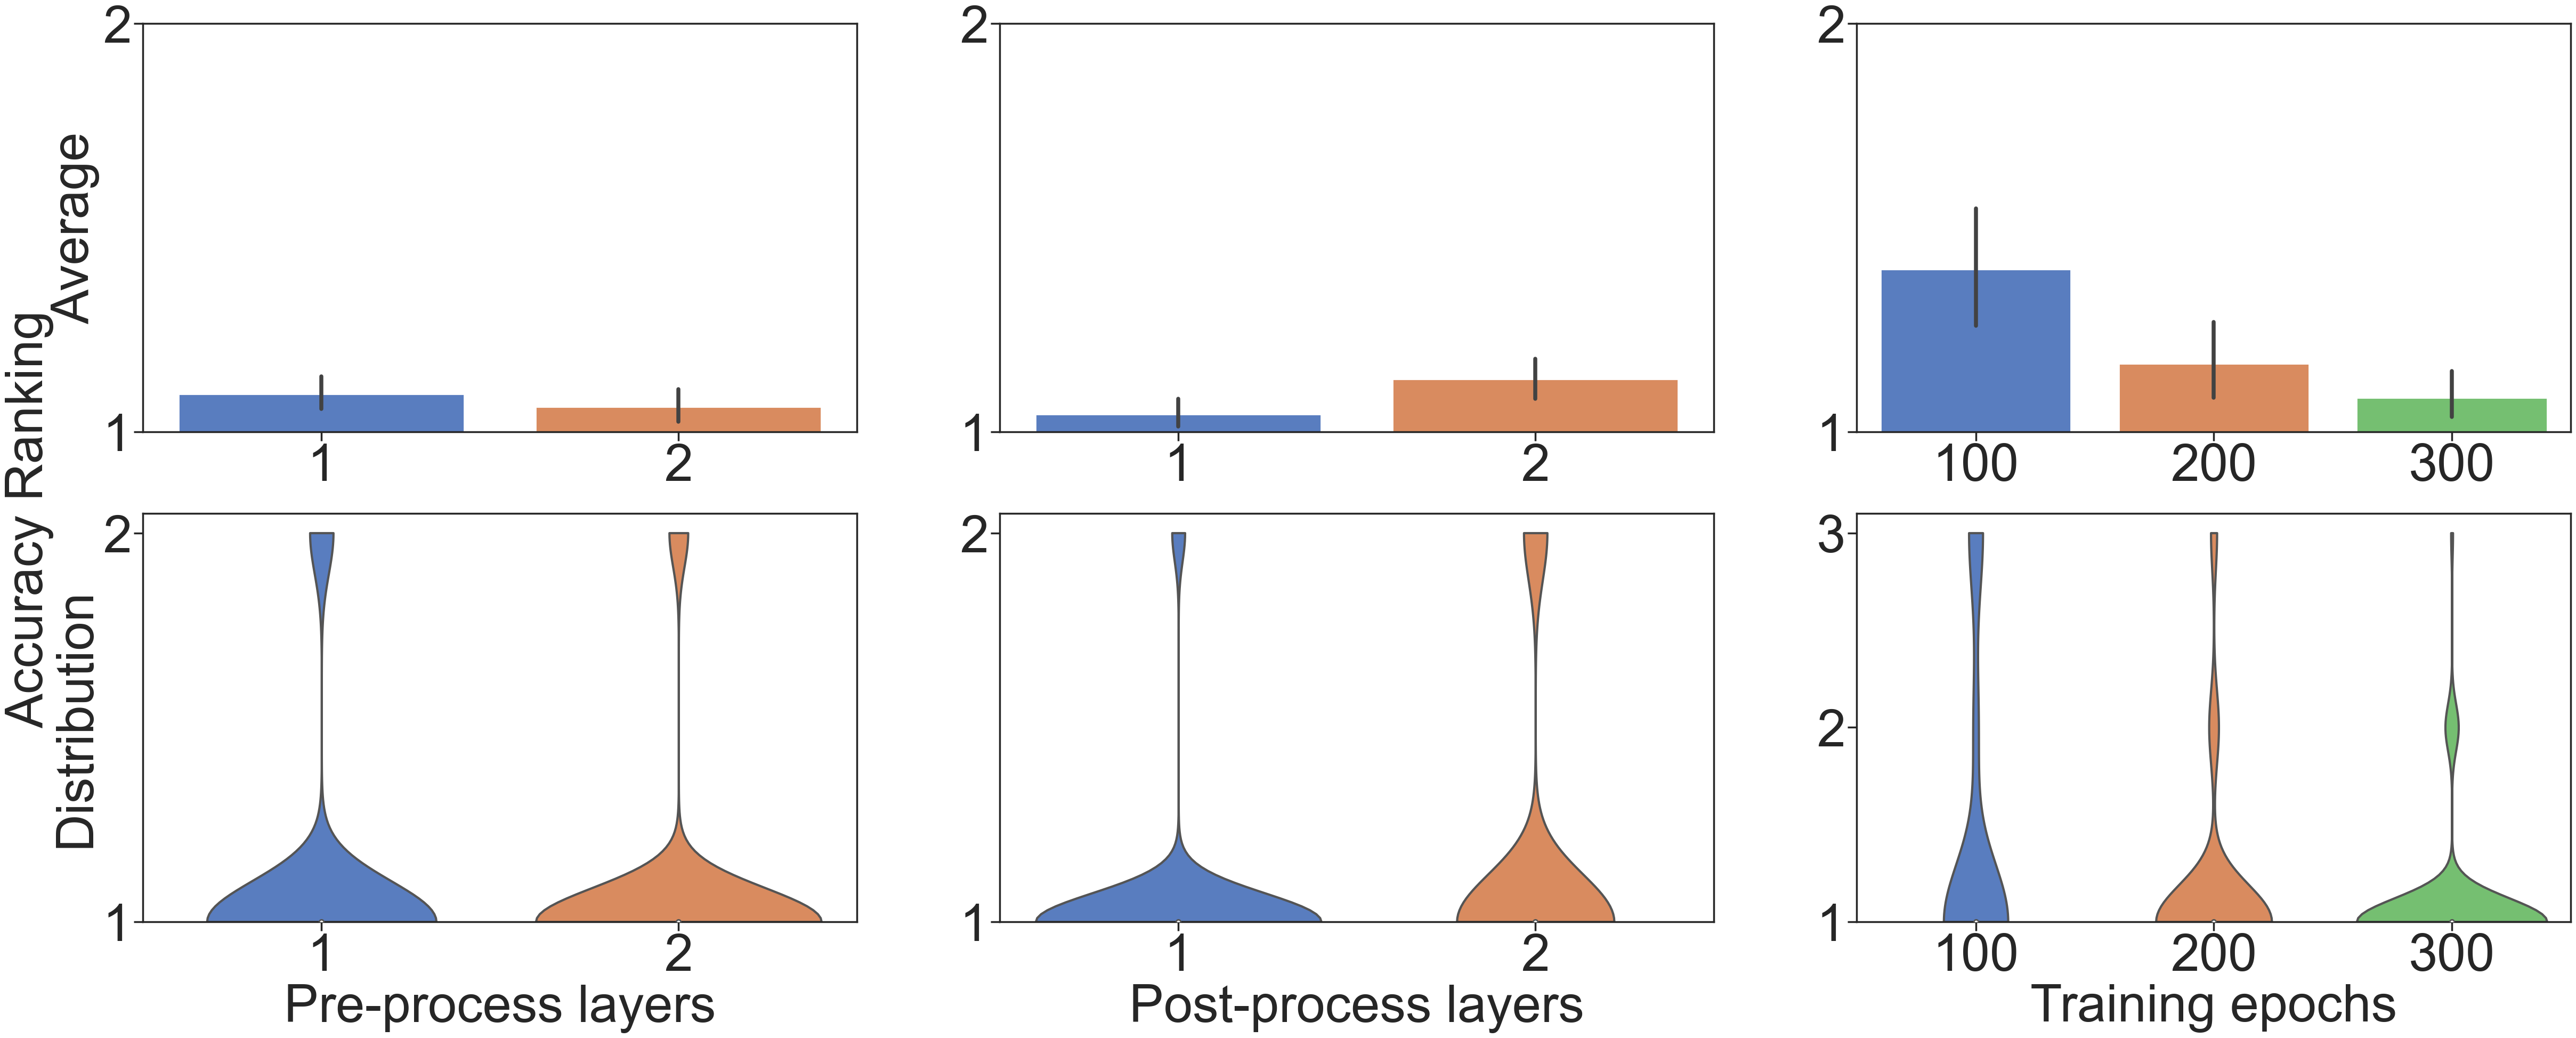

In [23]:
# (1) A general guideline for GNN design
# Trade-off analysis for each design dimension in the design space
# Figure 3 in "Design Space for Graph Neural Networks"
from scipy.stats import rankdata, ttest_ind, f_oneway
from matplotlib.ticker import MaxNLocator

results_file_path = '../../saved_results/yeast-gcnconv-grid/val.csv'
df = pd.read_csv(results_file_path)
df['epoch'] += 1
df.replace('skipconcat','skipcat',inplace=True)
df.replace('add','sum',inplace=True)


name_mapping = {'act': 'Activation', 'bn':'Batch Normalization', 'drop':'Dropout', 'agg':'Aggregation',
                'l_mp':'Message passing layers', 'l_pre':'Pre-process layers', 'l_post': 'Post-process layers', 'stage': 'Layer connectivity',
                'lr': 'Learning rate', 'batch':'Batch size', 'optim': 'Optimizer', 'epoch': 'Training epochs'}

column = ['l_pre', 'l_mp', 'l_post', 'stage',
          'drop', 'epoch']

def get_acc(df, name, ax, metric='acc', has_y=True):
    # df_selected = df[df['sample']==name].copy()
    df_selected = df.copy()
    df_selected[column] = df_selected[column].fillna('Nan')

    column_temp = copy.deepcopy(column)
    column_temp.remove(name)
    df_pivot = pd.pivot_table(df_selected, values='auc', index=column_temp, columns=[name], aggfunc=np.mean)
    accs_np = df_pivot.fillna(df_pivot.min()).values.round(2)
    options = df_pivot.columns.values
        
    ranks_raw = {'Model ID':[], 'Accuracy':[], 'Acc. Ranking':[], name_mapping[name]:[]}
    
    rank_np = np.zeros((accs_np.shape[0], accs_np.shape[1]))
    for i,row in enumerate(accs_np):
        # (1) rank is asceneding, so we neg the row; (2) rank start with 1 so we minus 1
        rank_base = -row
        med = np.median(rank_base)
        bias = 0.021
        for j in range(len(rank_base)):
            if abs(rank_base[j]-med) <= bias:
                rank_base[j] = med
        rank = rankdata(rank_base, method='min')
        for j in range(len(rank)):
            ranks_raw['Model ID'].append(i)
            ranks_raw['Accuracy'].append(accs_np[i,j])
            ranks_raw['Acc. Ranking'].append(rank[j])
            ranks_raw[name_mapping[name]].append(options[j])
            rank_np[i,j]=rank[j]

#     if metric == 'rank_bar':
#         p_value = f_oneway(*[rank_np[:,i] for i in range(rank_np.shape[1])])[1]
#         print(name, p_value, p_value<0.05, p_value<0.05/12)

    ranks_raw = pd.DataFrame(data=ranks_raw)     
    with sns.color_palette("muted"):
        if metric=='acc':
            splot = sns.violinplot(x=name_mapping[name], y="Accuracy",inner="box", data=ranks_raw, cut=0, ax=ax)
        elif metric=='rank_bar':
            splot = sns.barplot(x=name_mapping[name], y="Acc. Ranking",data=ranks_raw, ax=ax)
            ax.set_ylim(bottom=1)
            ax.set_yticks([1,2])
            ax.set_xlabel('',fontsize=70)
            if not has_y:
                ax.set_ylabel('',fontsize=70)
            else:
                ax.set_ylabel('Average',fontsize=70)
        elif metric=='rank_violin':
            sns.violinplot(x=name_mapping[name], y="Acc. Ranking",inner="box", data=ranks_raw, cut=0, ax=ax)
            ax.set_ylim(bottom=1)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            if not has_y:
                ax.set_ylabel('',fontsize=70)
            else:
                ax.set_ylabel('Distribution',fontsize=70)
        ax.xaxis.label.set_size(70)
        ax.yaxis.label.set_size(70)
        ax.tick_params(axis='both', which='major', labelsize=70)

for names in [['drop','l_mp','stage'], ['l_pre','l_post','epoch']]:
    col = 3
    row = 2
    f, axes = plt.subplots(nrows=row, ncols=col, figsize=(48, 20))
    
    for j,metric in enumerate(['rank_bar','rank_violin']):
        for i,name in enumerate(names):
            get_acc(df, name, axes[j, i], metric, has_y=i==0)
    f.text(-0.001, 0.5, 'Accuracy Ranking', ha='center', va='center', rotation='vertical', fontsize=70)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
#     f.savefig('figs/{}.png'.format(metric), dpi=150, bbox_inches='tight')
    
    plt.show()